In [689]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import re
import itertools

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

**Содержание ноутбука**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

*Обзор обучающего датасета*

In [690]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

In [691]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [692]:
df.iloc[0]

Home Ownership                            Own Home
Annual Income                               482087
Years in current job                           NaN
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Credit Default                                   0
Name: 0, dtype: object

In [693]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

In [694]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [695]:
TARGET_NAME = 'Credit Default'
NUM_FEATURE_NAMES = df.select_dtypes(include='float64').columns.tolist()
CAT_FEATURE_NAMES = df.select_dtypes(include='object').columns.tolist()

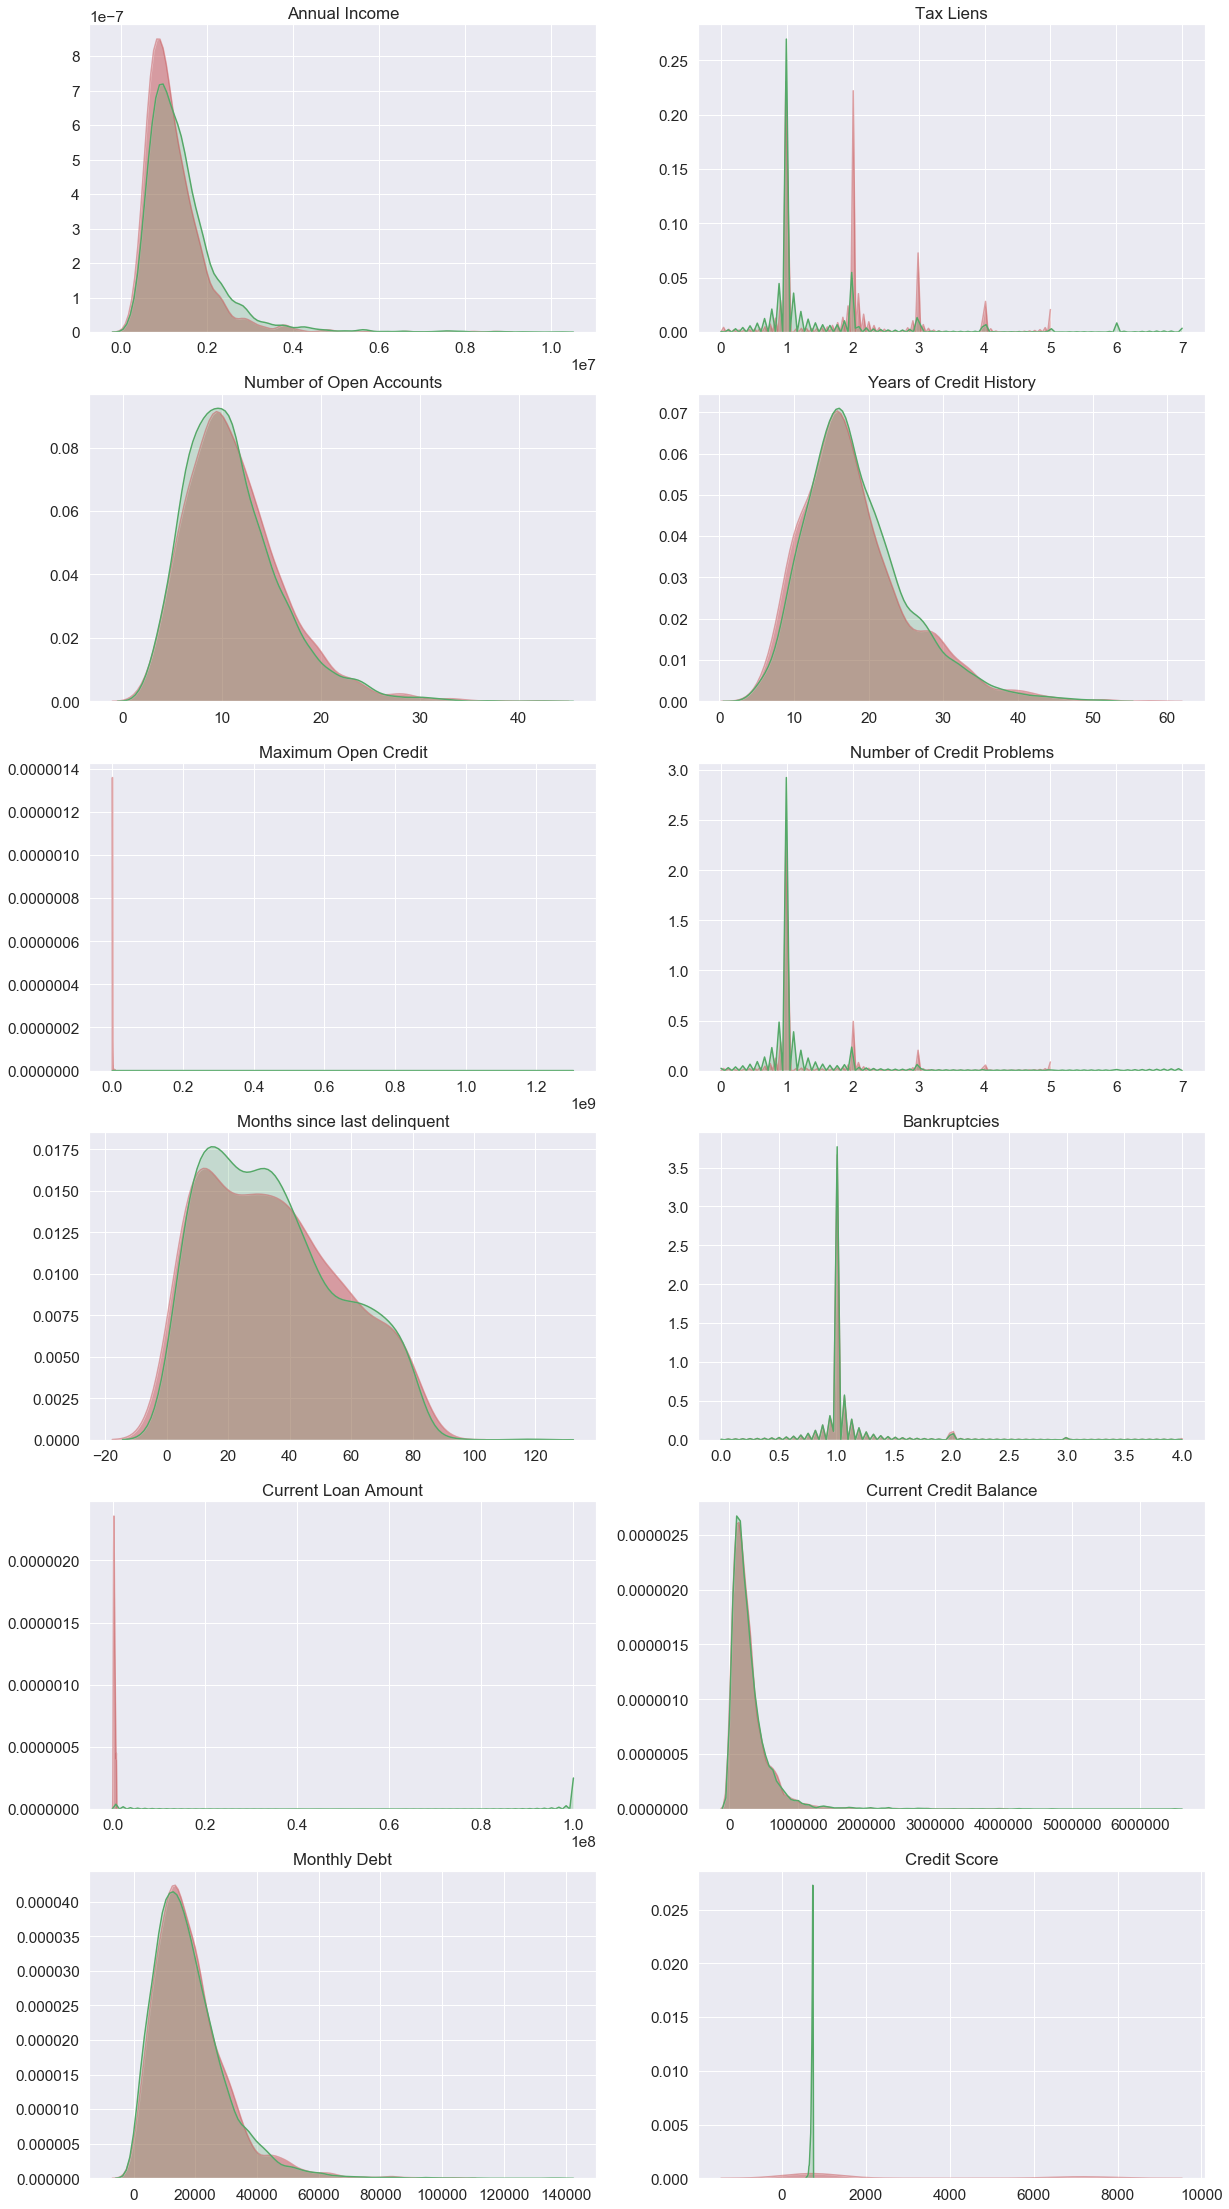

In [696]:
sns.set(font_scale=1.4)
plt.figure(figsize=(20,60))

for i, colname in enumerate(NUM_FEATURE_NAMES):
    plt.subplot(9,2,i+1)
    plt.title(colname)
    sns.kdeplot(df.loc[df[TARGET_NAME] == 1, colname].dropna(), shade=True, alpha=0.5, legend=False, color='r')
    sns.kdeplot(df.loc[df[TARGET_NAME] == 0, colname].dropna(), shade=True, legend=False, color='g')
    
plt.show()

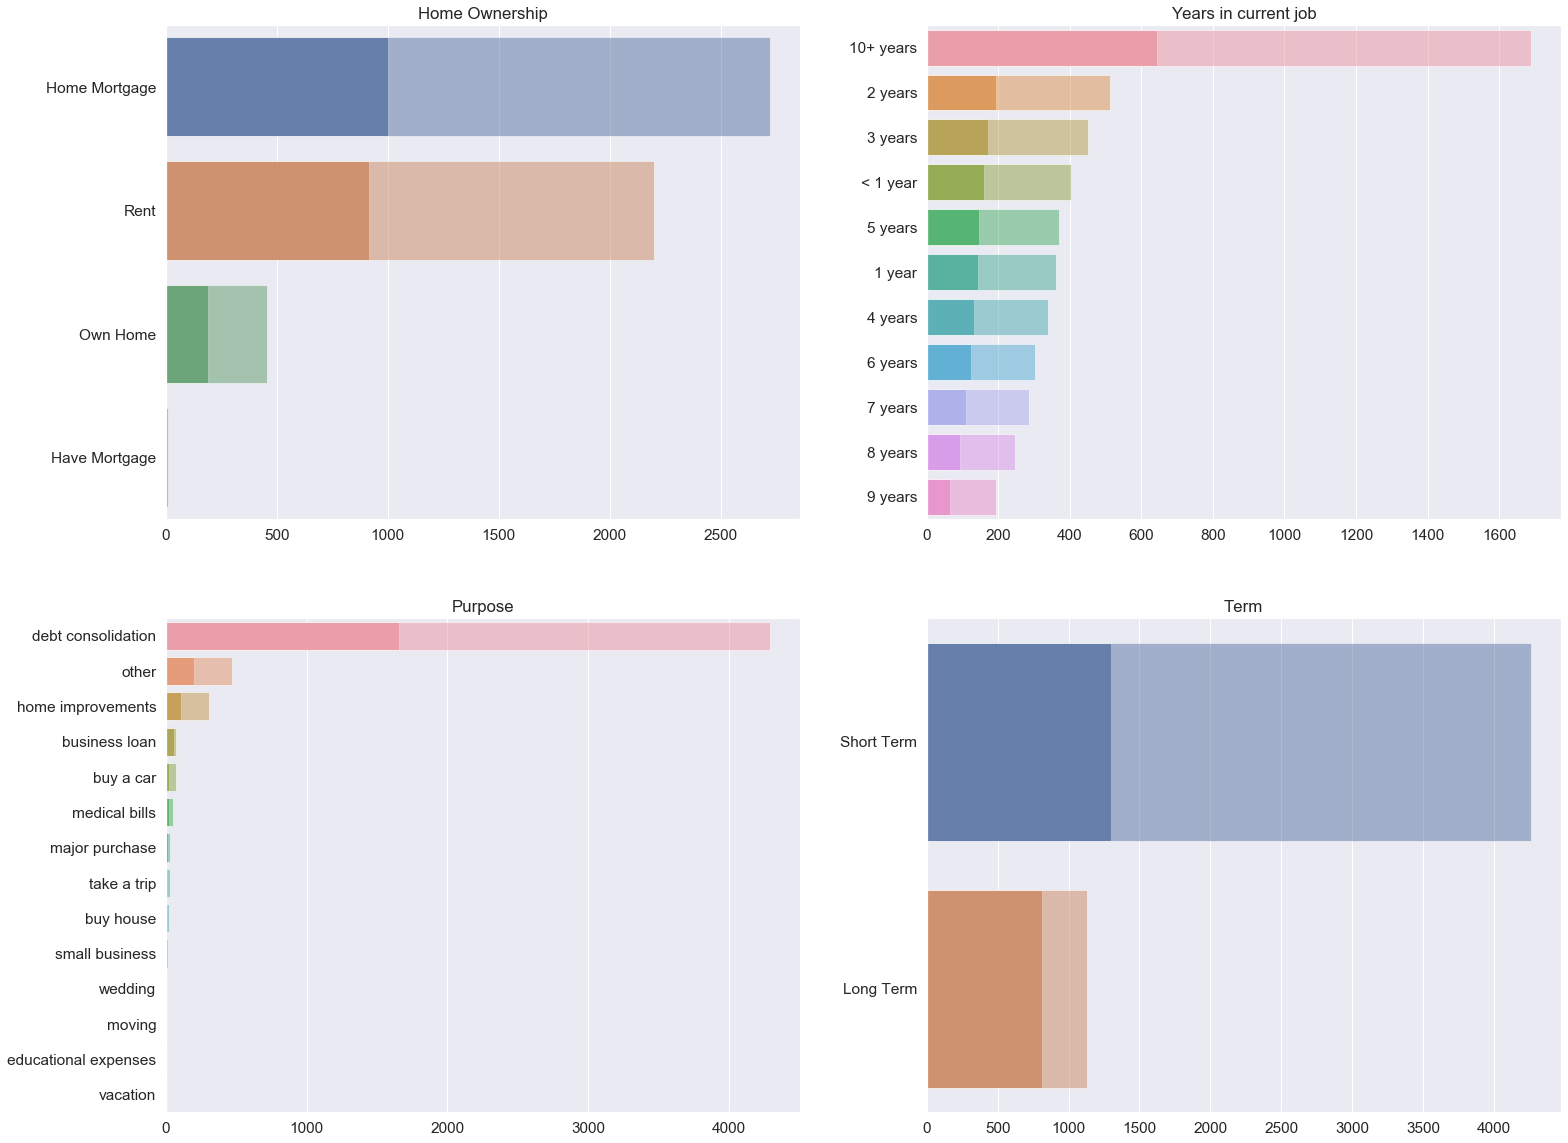

In [697]:
sns.set(font_scale=1.4)
plt.figure(figsize=(25,20))

for i, colname in enumerate(CAT_FEATURE_NAMES):
    plt.subplot(2,2,i+1)
    plt.title(colname)
    
    val_counts_t1 = df.loc[df[TARGET_NAME] == 1, colname].value_counts()
    val_counts_t0 = df.loc[df[TARGET_NAME] == 0, colname].value_counts()
    
    sns.barplot(val_counts_t1.values, val_counts_t1.index, alpha=0.8)
    sns.barplot(val_counts_t0.values, val_counts_t0.index, alpha=0.5)
    
plt.show()

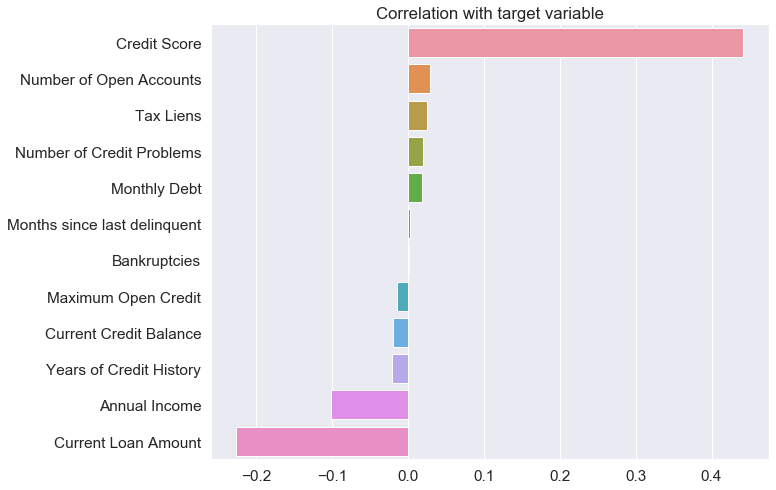

In [698]:
corr_with_target = df.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

*Обработка выбросов*


In [699]:
df['Years in current job'] = df['Years in current job'].str.extract('(\d+)').fillna(0).astype(np.int64)

In [700]:
TARGET_NAME = 'Credit Default'
NONNUMERIC_FEATURE_NAMES = ['Home Ownership', 'Purpose', 'Term']
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
NUMERIC_FEATURE_NAMES = df.columns.drop(TARGET_NAME).drop(NONNUMERIC_FEATURE_NAMES).tolist()

In [701]:
NUMERIC_FEATURE_NAMES

['Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

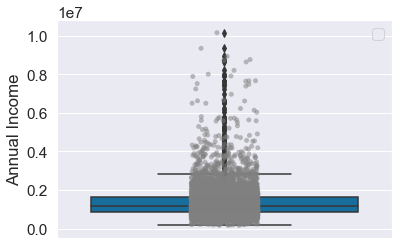

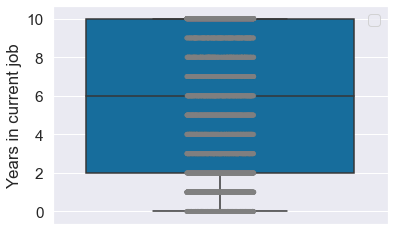

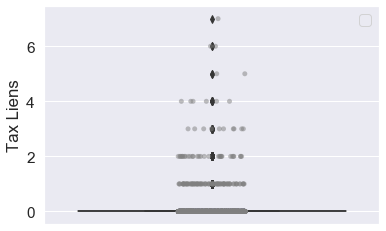

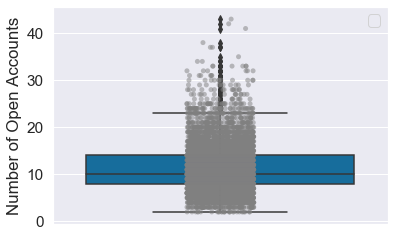

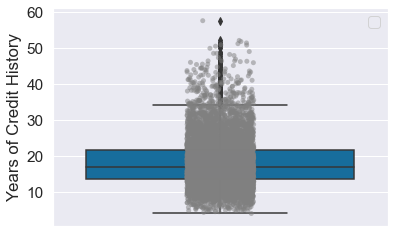

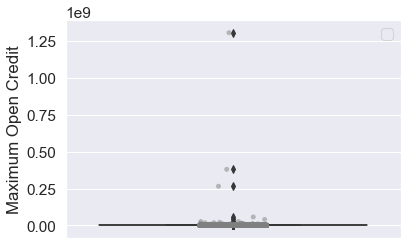

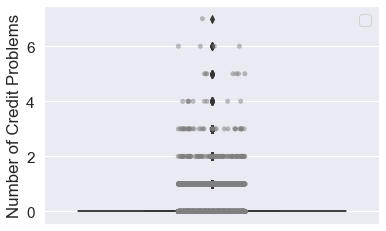

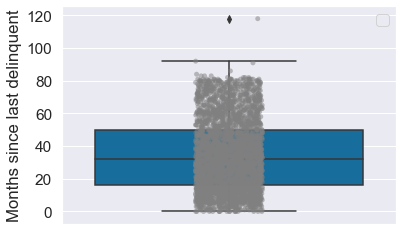

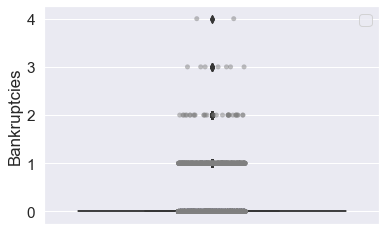

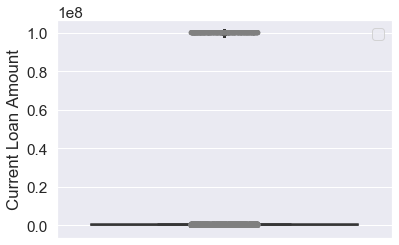

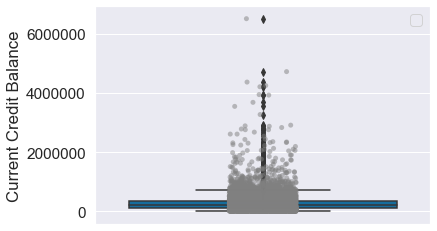

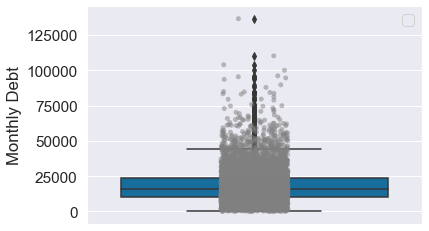

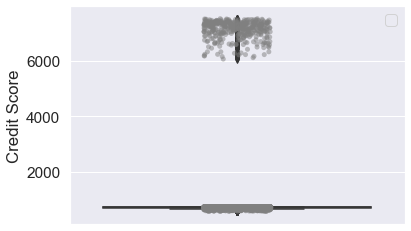

In [702]:
for col in NUMERIC_FEATURE_NAMES:
  plt.figure(col)
  bp = sns.boxplot(y=col, 
                 data=df, 
                 palette="colorblind", 
                 hue='Credit Default')
 
  bp = sns.stripplot(y=col,  
                   data=df, 
                   jitter=True,
                   dodge=True, 
                   marker='o', 
                   alpha=0.5,
                   hue='Credit Default',
                   color='grey')
  handles, labels = bp.get_legend_handles_labels()
  l = plt.legend(handles[0:2], labels[0:2])

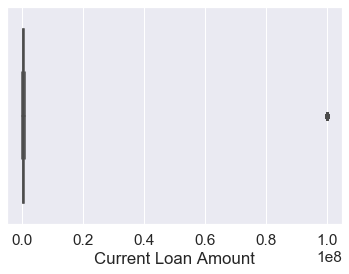

In [703]:
sns.boxplot(df['Current Loan Amount'])

In [704]:
moc_q90 = df['Maximum Open Credit'].quantile(.9)

In [705]:
df.loc[df['Maximum Open Credit'] > moc_q90, 'Maximum Open Credit'] = moc_q90

In [706]:
ccb_q90 = df['Current Credit Balance'].quantile(.99)

In [707]:
df.loc[df['Current Credit Balance'] > ccb_q90, 'Current Credit Balance'] = ccb_q90

In [708]:
def clean_credit_score(df):
    df.loc[df['Credit Score'] > 900, 'Credit Score'] = df['Credit Score'] / 10
    return df

In [709]:
clean_credit_score(df)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,0,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,1,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,741.0,1
7497,Rent,1878910.0,6,0.0,12.0,32.1,1245904.0,0.0,NaN,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,0,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0


In [710]:
current_amount_mean = round(df['Current Loan Amount'].replace(99999999.0, np.nan).mean())

In [711]:
df.loc[df['Current Loan Amount'] == 99999999.0, 'Current Loan Amount'] = current_amount_mean

In [712]:
df.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,0,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,309024.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,309024.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
5,Rent,NaN,7,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
6,Home Mortgage,1511108.0,10,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,309024.0,51623.0,2317.0,745.0,0
7,Rent,1040060.0,10,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1
8,Home Mortgage,NaN,5,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1


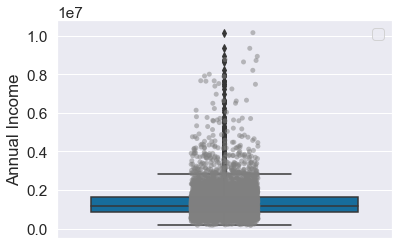

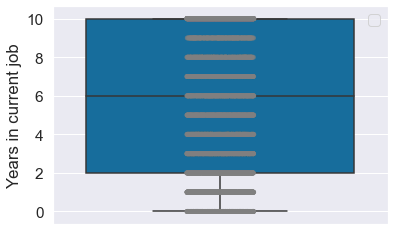

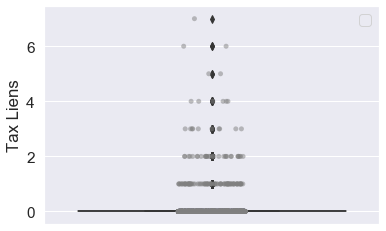

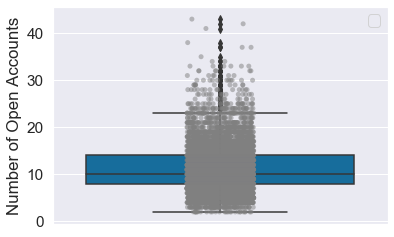

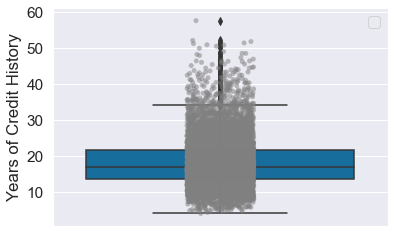

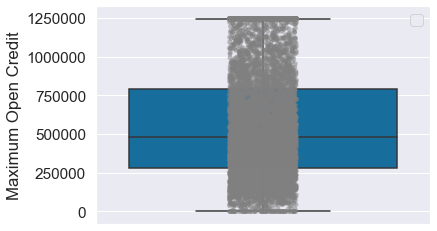

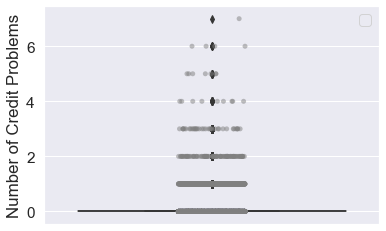

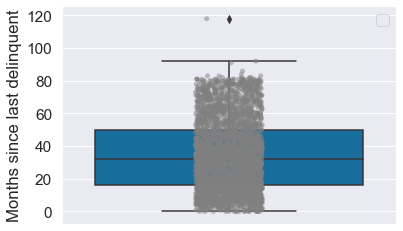

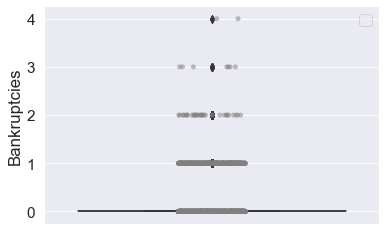

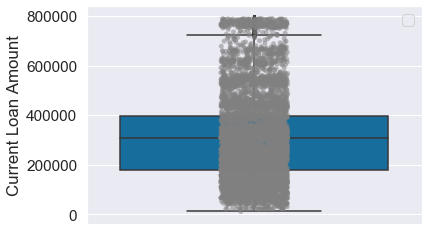

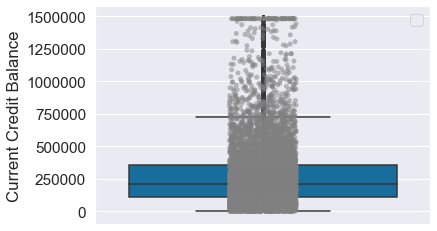

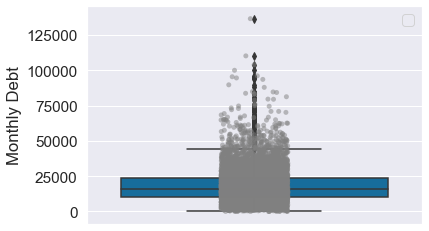

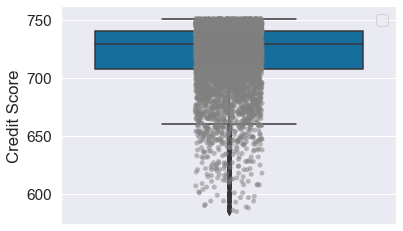

In [713]:
for col in NUMERIC_FEATURE_NAMES:
  plt.figure(col)
  bp = sns.boxplot(y=col, 
                 data=df, 
                 palette="colorblind", 
                 hue='Credit Default')
 
  bp = sns.stripplot(y=col,  
                   data=df, 
                   jitter=True,
                   dodge=True, 
                   marker='o', 
                   alpha=0.5,
                   hue='Credit Default',
                   color='grey')
  handles, labels = bp.get_legend_handles_labels()
  l = plt.legend(handles[0:2], labels[0:2])

*Обработка пропусков*

In [714]:
df['Annual Income'].fillna((df['Annual Income'].mean()), inplace=True)

In [715]:
df['Credit Score'].fillna((df['Credit Score'].mean()), inplace=True)

In [716]:
df['Bankruptcies'].fillna(round(df['Bankruptcies'].mean()), inplace=True)

In [717]:
df['Months since last delinquent'].fillna(0, inplace=True)

In [718]:
df['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [719]:
df.loc[df['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'

In [720]:
df['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [721]:
df.loc[~df['Purpose'].isin(['debt consolidation',
                            'other', 'home improvements', 
                            'business loan']), 'Purpose'] = 'other'

In [722]:
df['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [723]:
replace_dict = {'Short Term':0, 'Long Term':1}

df['Term'].replace(replace_dict, inplace=True)

In [724]:
df['Home Ownership'] = df['Home Ownership'].astype('category')
df['Purpose'] = df['Purpose'].astype('category')
df = pd.get_dummies(df)

In [725]:
df.head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,...,Monthly Debt,Credit Score,Credit Default,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_business loan,Purpose_debt consolidation,Purpose_home improvements,Purpose_other
0,482087.0,0,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,0,...,7914.0,749.0,0,0,1,0,0,1,0,0
1,1025487.0,10,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,1,...,18373.0,737.0,1,0,1,0,0,1,0,0
2,751412.0,8,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,0,...,13651.0,742.0,0,1,0,0,0,1,0,0
3,805068.0,6,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,0,...,11338.0,694.0,0,0,1,0,0,1,0,0
4,776264.0,8,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,0,...,7180.0,719.0,0,0,0,1,0,1,0,0


In [726]:
df['Income to Payment'] = df['Annual Income'] / (df['Monthly Debt'] + 1) 
# добавил 1 доллар к платежу, чтобы избежать бесконечности 

In [727]:
df['Loan to Income'] = (df['Current Loan Amount'] + df['Current Credit Balance']) / df['Annual Income']

In [728]:
important_features = ['Annual Income', 'Current Loan Amount',
                      'Credit Score', 'Maximum Open Credit', 'Monthly Debt']

In [729]:
n = 3
component_names = ['component_' + str(i+1) for i in range(n)]

In [730]:
pca = PCA(n_components=n)

components = pca.fit_transform(df[important_features])
components = pd.DataFrame(data=components, columns=component_names)

In [731]:
df = pd.concat([df, components], axis=1)

*Анализ данных*

In [732]:
df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

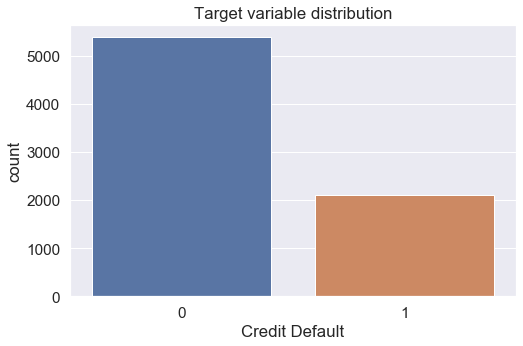

In [733]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df)

plt.title('Target variable distribution')
plt.show()

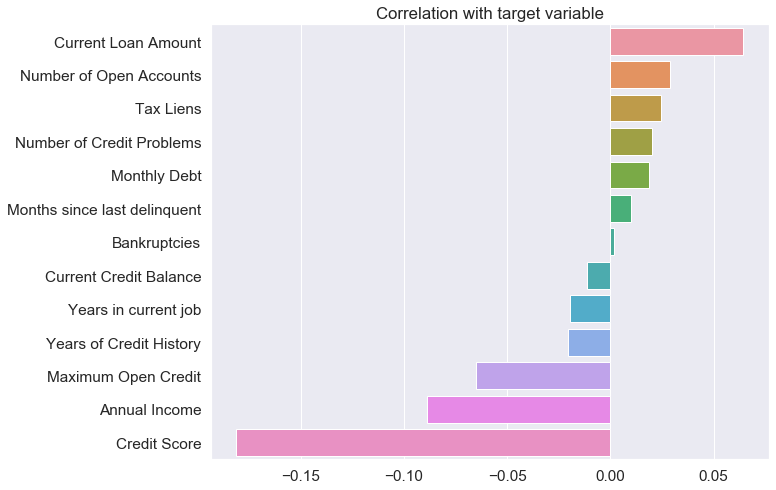

In [734]:
corr_with_target = df[NUMERIC_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

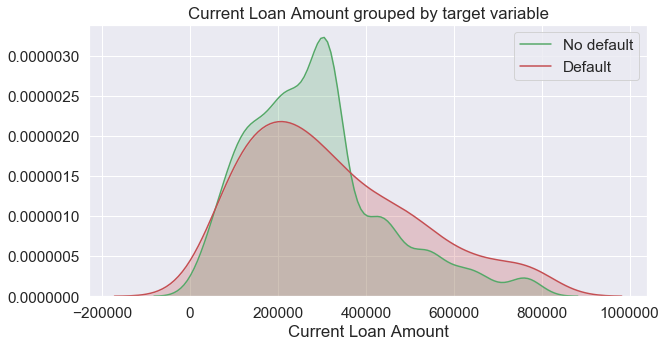

In [735]:
cla_with_target = df[['Current Loan Amount', TARGET_NAME]].sample(1000)
cla = cla_with_target['Current Loan Amount']
cla_target_0 = cla[cla_with_target[TARGET_NAME] == 0]
cla_target_1 = cla[cla_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(cla_target_0, shade=True, label='No default', color='g')
sns.kdeplot(cla_target_1, shade=True, label='Default', color='r')

plt.xlabel('Current Loan Amount')
plt.title('Current Loan Amount grouped by target variable')
plt.show()

In [736]:
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

In [737]:
shapiro(cla)

(0.9392682909965515, 8.754478291417186e-20)

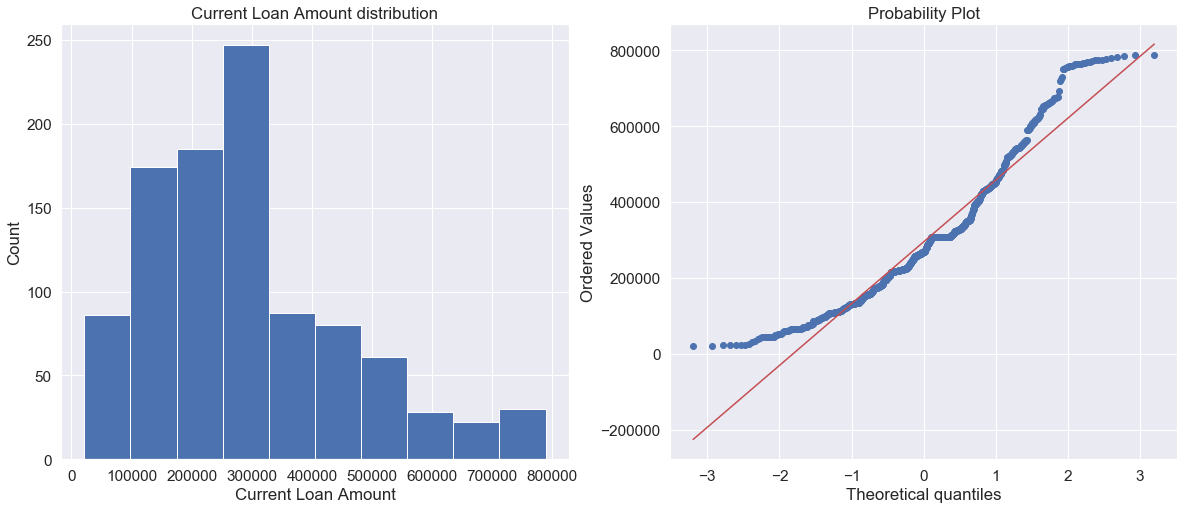

In [738]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Current Loan Amount')
ax1.set_ylabel('Count')
ax1.set_title('Current Loan Amount distribution')
cla.hist()

plt.subplot(122)
probplot(cla, dist='norm', plot=plt)

plt.show()

In [739]:
mannwhitneyu(cla_target_0, cla_target_1)

MannwhitneyuResult(statistic=94470.5, pvalue=0.011129235957754127)

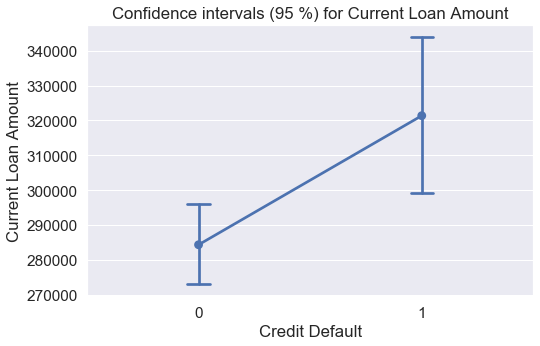

In [740]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Current Loan Amount', data=cla_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Current Loan Amount')
plt.show()

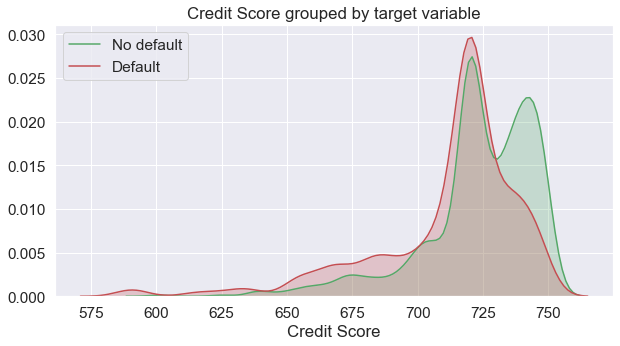

In [741]:
cs_with_target = df[['Credit Score', TARGET_NAME]].sample(1000)
cs = cs_with_target['Credit Score']
cs_target_0 = cs[cs_with_target[TARGET_NAME] == 0]
cs_target_1 = cs[cs_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(cs_target_0, shade=True, label='No default', color='g')
sns.kdeplot(cs_target_1, shade=True, label='Default', color='r')

plt.xlabel('Credit Score')
plt.title('Credit Score grouped by target variable')
plt.show()

In [742]:
shapiro(cs)

(0.8511750102043152, 1.1916794598240702e-29)

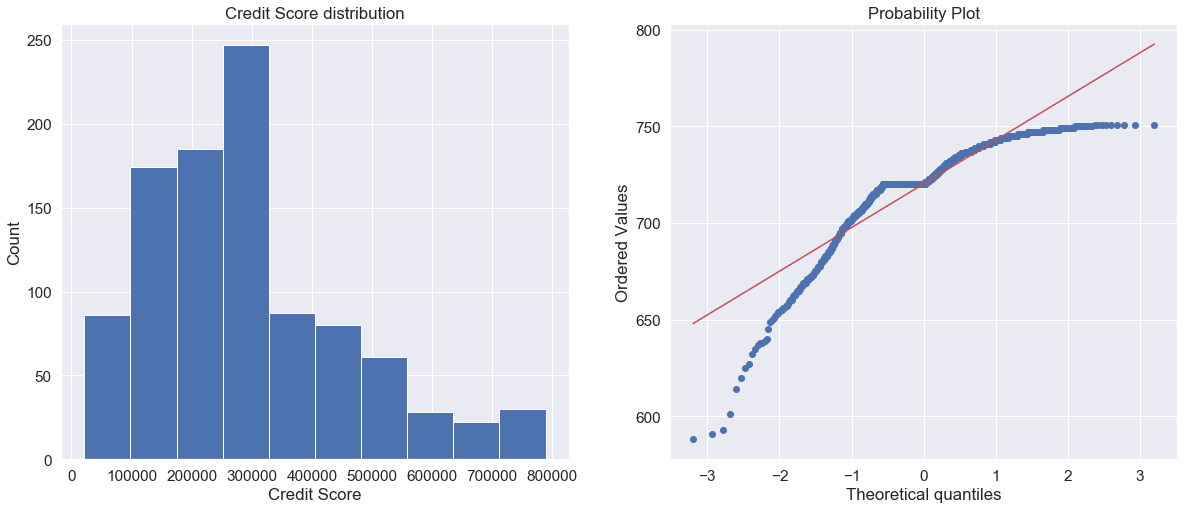

In [743]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Credit Score')
ax1.set_ylabel('Count')
ax1.set_title('Credit Score distribution')
cla.hist()

plt.subplot(122)
probplot(cs, dist='norm', plot=plt)

plt.show()

In [744]:
mannwhitneyu(cs_target_0, cs_target_1)

MannwhitneyuResult(statistic=70086.5, pvalue=4.252032927964085e-13)

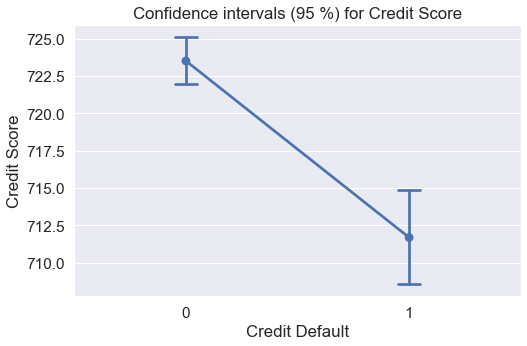

In [745]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Credit Score', data=cs_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Credit Score')
plt.show()

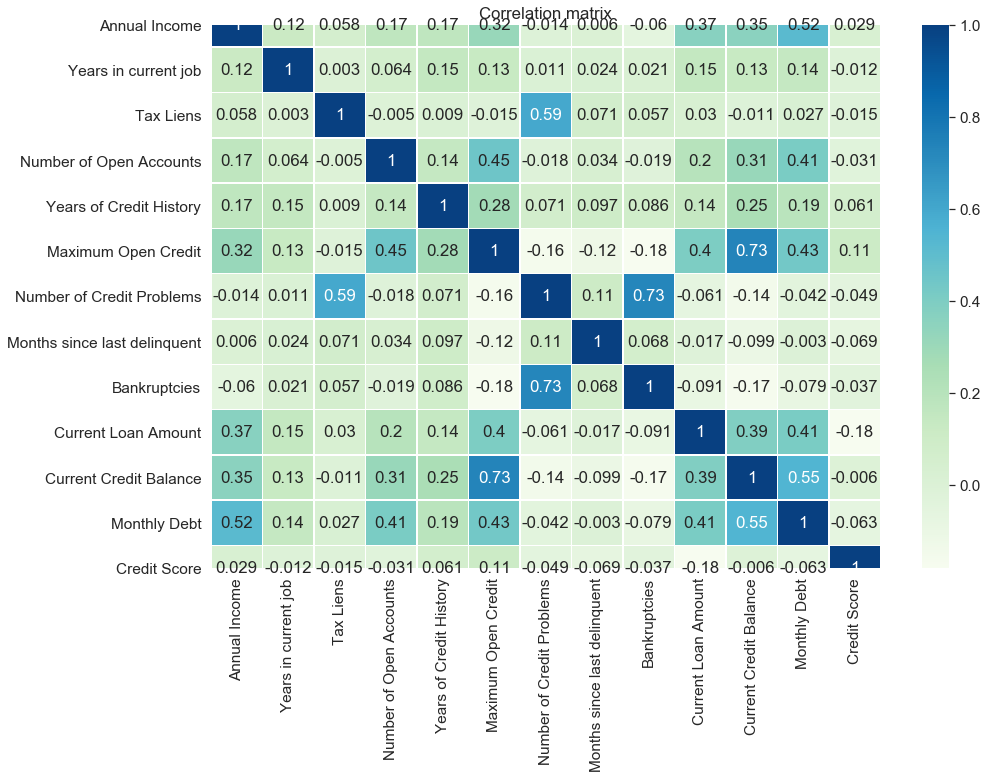

In [746]:
plt.figure(figsize = (15, 10))

sns.set(font_scale=1.4)
sns.heatmap(df[NUMERIC_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [747]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [748]:
target_counts = df[TARGET_NAME].value_counts().to_frame()
scale_pos_weight = target_counts[TARGET_NAME].max() / target_counts[TARGET_NAME].min()
scale_pos_weight

2.549455750118315

*Отбор признаков*

In [749]:
NUMERIC_FEATURE_NAMES

['Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [750]:
NUMERIC_FEATURE_NAMES.extend(component_names)

In [751]:
NUMERIC_FEATURE_NAMES.extend(['Income to Payment', 'Loan to Income'])

In [752]:
BASE_FEATURE_NAMES

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [753]:
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME]).tolist() 

In [754]:
NEW_FEATURE_NAMES = [x for x in NEW_FEATURE_NAMES if x not in NUMERIC_FEATURE_NAMES]

In [755]:
NEW_FEATURE_NAMES

['Term',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Purpose_business loan',
 'Purpose_debt consolidation',
 'Purpose_home improvements',
 'Purpose_other']

In [756]:
FEATURE_NAMES_SELECTED = NUMERIC_FEATURE_NAMES + NEW_FEATURE_NAMES

In [758]:
df.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,...,Home Ownership_Rent,Purpose_business loan,Purpose_debt consolidation,Purpose_home improvements,Purpose_other,Income to Payment,Loan to Income,component_1,component_2,component_3
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,...,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7.500000e+03,7.500000e+03,7.500000e+03
mean,1.366392e+06,5.664533,0.030133,11.130933,18.317467,5.629516e+05,0.170000,15.815200,0.116933,0.259200,...,0.427200,0.017200,0.792533,0.054933,0.135333,1.001260e+03,0.470201,7.193109e-11,-4.492661e-11,4.699298e-12
std,7.524812e+05,3.648694,0.271604,4.908924,7.041946,3.547921e+05,0.498598,22.649441,0.346904,0.438225,...,0.494705,0.130025,0.405520,0.227865,0.342102,3.263402e+04,0.252510,7.658104e+05,3.361754e+05,1.485093e+05
min,1.645970e+05,0.000000,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.420691e+01,0.016230,-1.268961e+06,-8.607186e+05,-5.459473e+05
25%,9.311330e+05,2.000000,0.000000,8.000000,13.500000,2.792295e+05,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,5.333224e+01,0.287245,-4.579876e+05,-2.152197e+05,-8.387713e+04
50%,1.366392e+06,6.000000,0.000000,10.000000,17.000000,4.781590e+05,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,7.361605e+01,0.427598,-6.375475e+04,6.315563e+04,1.316960e+04
75%,1.499974e+06,10.000000,0.000000,14.000000,21.800000,7.935015e+05,0.000000,29.000000,0.000000,1.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,1.121394e+02,0.611610,1.602025e+05,2.460532e+05,9.908778e+04
max,1.014934e+07,10.000000,7.000000,43.000000,57.700000,1.245904e+06,7.000000,118.000000,4.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.366392e+06,2.328545,8.575146e+06,2.000168e+06,6.063093e+05


*Балансировка классов*

*Подбор моделей, получение бейзлайна*

In [759]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[NUMERIC_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUMERIC_FEATURE_NAMES])

df = df_norm.copy()

In [760]:
X = df[FEATURE_NAMES_SELECTED]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=42)

In [761]:
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

Series([], dtype: float64)

*Логистическая регрессия*

In [762]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.96      0.84      4074
           1       0.54      0.13      0.21      1551

    accuracy                           0.73      5625
   macro avg       0.64      0.54      0.52      5625
weighted avg       0.69      0.73      0.66      5625

TEST

              precision    recall  f1-score   support

           0       0.71      0.95      0.82      1313
           1       0.49      0.11      0.18       562

    accuracy                           0.70      1875
   macro avg       0.60      0.53      0.50      1875
weighted avg       0.65      0.70      0.62      1875

CONFUSION MATRIX

col_0              0   1
Credit Default          
0               1250  63
1                502  60


*k ближайших соседей*

In [763]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.93      0.86      4074
           1       0.69      0.38      0.49      1551

    accuracy                           0.78      5625
   macro avg       0.74      0.66      0.68      5625
weighted avg       0.77      0.78      0.76      5625

TEST

              precision    recall  f1-score   support

           0       0.72      0.87      0.79      1313
           1       0.42      0.23      0.29       562

    accuracy                           0.68      1875
   macro avg       0.57      0.55      0.54      1875
weighted avg       0.63      0.68      0.64      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1140  173
1                435  127


*XGBoost*

In [764]:
model_xgb = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.68      0.77      4074
           1       0.48      0.78      0.59      1551

    accuracy                           0.71      5625
   macro avg       0.69      0.73      0.68      5625
weighted avg       0.78      0.71      0.72      5625

TEST

              precision    recall  f1-score   support

           0       0.80      0.62      0.70      1313
           1       0.41      0.63      0.50       562

    accuracy                           0.62      1875
   macro avg       0.60      0.62      0.60      1875
weighted avg       0.68      0.62      0.64      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               811  502
1               208  354


*LightGBM*

In [765]:
model_lgbm = lgbm.LGBMClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.99      0.89      0.94      4074
           1       0.77      0.97      0.86      1551

    accuracy                           0.91      5625
   macro avg       0.88      0.93      0.90      5625
weighted avg       0.93      0.91      0.91      5625

TEST

              precision    recall  f1-score   support

           0       0.78      0.72      0.75      1313
           1       0.44      0.51      0.47       562

    accuracy                           0.66      1875
   macro avg       0.61      0.62      0.61      1875
weighted avg       0.68      0.66      0.67      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               946  367
1               273  289


*CatBoost*

In [766]:
model_catb = catb.CatBoostClassifier(silent=True, scale_pos_weight=scale_pos_weight,random_state=42)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      4074
           1       0.75      0.95      0.84      1551

    accuracy                           0.90      5625
   macro avg       0.86      0.91      0.88      5625
weighted avg       0.92      0.90      0.90      5625

TEST

              precision    recall  f1-score   support

           0       0.77      0.70      0.73      1313
           1       0.42      0.51      0.46       562

    accuracy                           0.64      1875
   macro avg       0.60      0.61      0.60      1875
weighted avg       0.67      0.64      0.65      1875

CONFUSION MATRIX

col_0           0.0  1.0
Credit Default          
0               920  393
1               275  287


*Выбор лучшей модели и подбор гиперпараметров*

In [767]:
xgb_clf = xgb.XGBClassifier(tree_method = 'exact', predictor = 'cpu_predictor',
                           objective = 'binary:logistic', 
                            scale_pos_weight=scale_pos_weight, random_state=42, silent = True)

In [768]:
parameters = {"learning_rate": [0.1, 0.01, 0.001],
               "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
               "max_depth": [2, 4, 7, 10],
               "colsample_bytree": [0.3, 0.6, 0.8, 0.9],
               "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
               "reg_alpha": [0, 1e-5, 1e-2, 0.1, 0.5, 1, 100],
               "reg_lambda": [1, 1.5, 2, 3, 4.5],
               "min_child_weight": [1, 3, 5, 7, 10, 12],
               "n_estimators": [100, 250, 500, 1000, 2000]}

In [769]:
cv=KFold(n_splits=5, random_state=42, shuffle=True)

In [847]:
%%time
rs = RandomizedSearchCV(xgb_clf, parameters, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)

Wall time: 1min 50s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective...
                                        'gamma': [0.01, 0.1, 0.3, 0.5, 1, 1.5,
                                                  2],
                                        'learning_rate': [0.1, 0.01, 0.001],
                                    

In [848]:
rs.best_params_

{'subsample': 0.5,
 'reg_lambda': 3,
 'reg_alpha': 0.5,
 'n_estimators': 100,
 'min_child_weight': 10,
 'max_depth': 2,
 'learning_rate': 0.1,
 'gamma': 1,
 'colsample_bytree': 0.6}

In [849]:
rs.best_score_

0.5035162595204358

In [850]:
%%time

final_model = xgb.XGBClassifier(tree_method = 'exact', 
                                predictor = 'cpu_predictor',
                                objective = 'binary:logistic',
                                scale_pos_weight=scale_pos_weight, 
                                random_state=42, 
                                silent = True,
                                learning_rate = 0.1,
                                gamma = 1,
                                max_depth = 2, 
                                colsample_bytree = 0.6, 
                                subsample = 0.5,
                                reg_alpha = 0.5,
                                reg_lambda = 3,
                                min_child_weight = 10,
                                n_estimators = 100)

final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.65      0.74      4074
           1       0.44      0.73      0.55      1551

    accuracy                           0.67      5625
   macro avg       0.65      0.69      0.64      5625
weighted avg       0.75      0.67      0.69      5625

TEST

              precision    recall  f1-score   support

           0       0.80      0.61      0.69      1313
           1       0.42      0.65      0.51       562

    accuracy                           0.62      1875
   macro avg       0.61      0.63      0.60      1875
weighted avg       0.69      0.62      0.64      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               802  511
1               196  366
Wall time: 652 ms


*Проверка качества, борьба с переобучением*

In [851]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [852]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [853]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [854]:
final_model = xgb.XGBClassifier(tree_method = 'exact', 
                                predictor = 'cpu_predictor',
                                objective = 'binary:logistic',
                                scale_pos_weight=scale_pos_weight, 
                                random_state=42, 
                                silent = True,
                                learning_rate = 0.1,
                                gamma = 1,
                                max_depth = 2, 
                                colsample_bytree = 0.6, 
                                subsample = 0.5,
                                reg_alpha = 0.5,
                                reg_lambda = 3,
                                min_child_weight = 10,
                                n_estimators = 100)

final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.65      0.74      4074
           1       0.44      0.73      0.55      1551

    accuracy                           0.67      5625
   macro avg       0.65      0.69      0.64      5625
weighted avg       0.75      0.67      0.69      5625

TEST

              precision    recall  f1-score   support

           0       0.80      0.61      0.69      1313
           1       0.42      0.65      0.51       562

    accuracy                           0.62      1875
   macro avg       0.61      0.63      0.60      1875
weighted avg       0.69      0.62      0.64      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               802  511
1               196  366


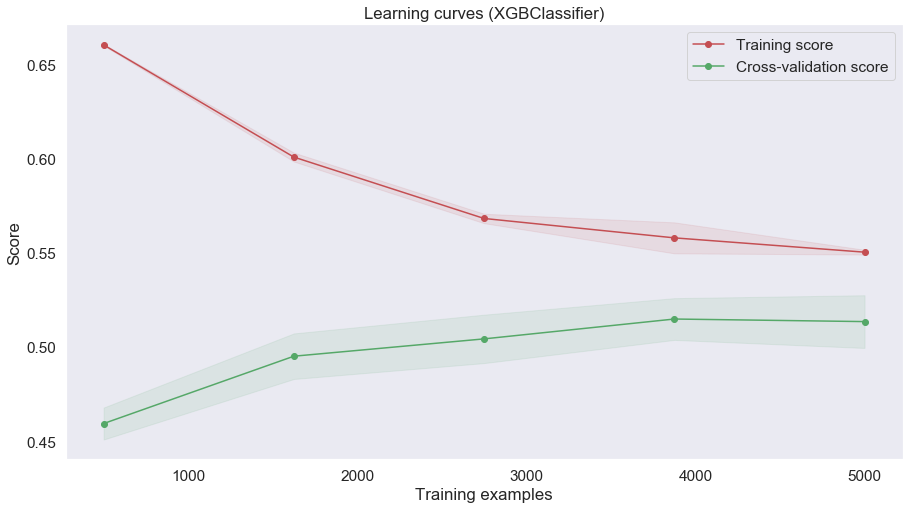

In [855]:
show_learning_curve_plot(final_model, X, y)

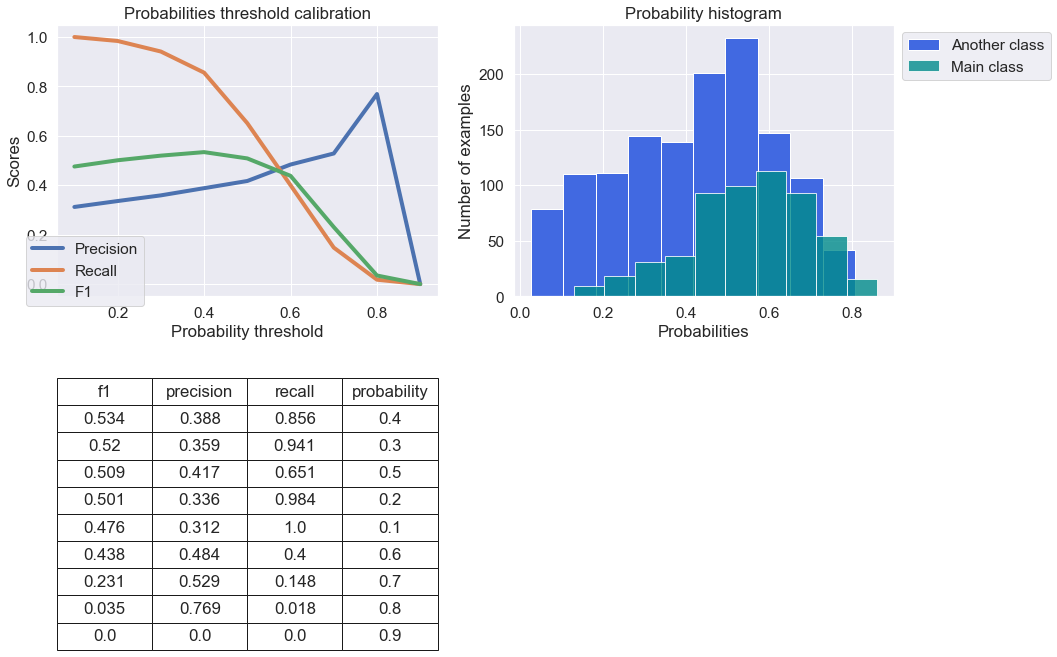

In [856]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

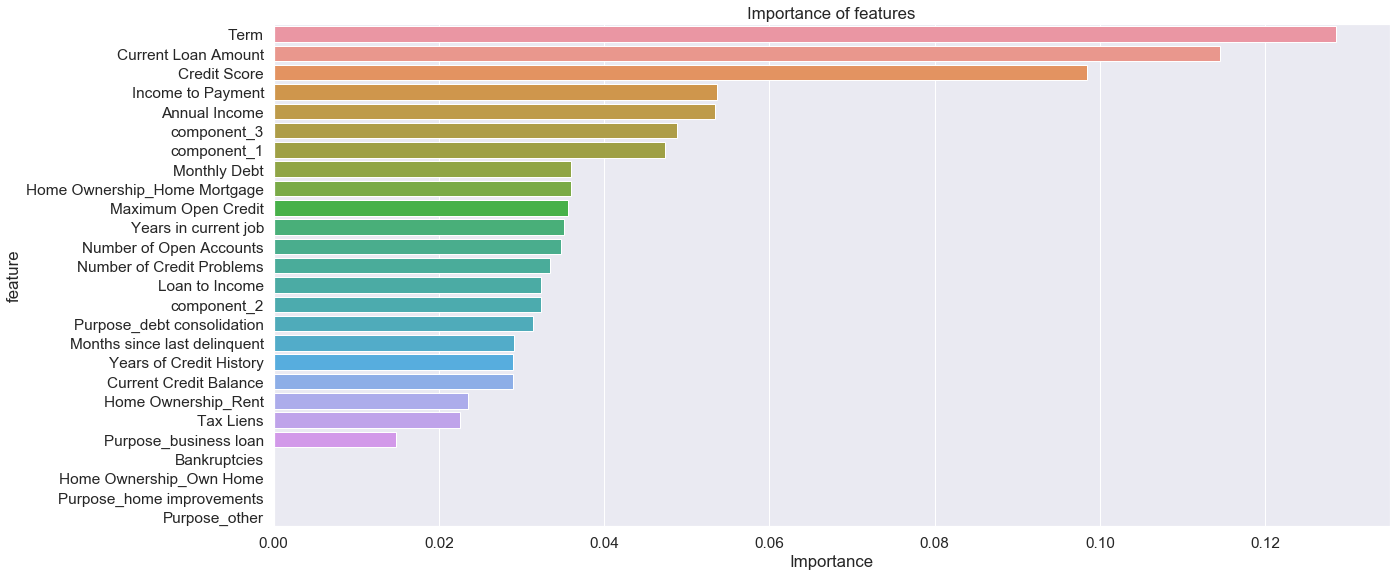

In [857]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=15)

In [858]:
important_features_top

['Term',
 'Current Loan Amount',
 'Credit Score',
 'Income to Payment',
 'Annual Income',
 'component_3',
 'component_1',
 'Monthly Debt',
 'Home Ownership_Home Mortgage',
 'Maximum Open Credit',
 'Years in current job',
 'Number of Open Accounts',
 'Number of Credit Problems',
 'Loan to Income',
 'component_2']

In [859]:
final_model = xgb.XGBClassifier(tree_method = 'exact', 
                                predictor = 'cpu_predictor',
                                objective = 'binary:logistic',
                                scale_pos_weight=scale_pos_weight, 
                                random_state=42, 
                                silent = True,
                                learning_rate = 0.1,
                                gamma = 1,
                                max_depth = 2, 
                                colsample_bytree = 0.6, 
                                subsample = 0.5,
                                reg_alpha = 0.5,
                                reg_lambda = 3,
                                min_child_weight = 10,
                                n_estimators = 100)


final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.64      0.73      4074
           1       0.43      0.72      0.54      1551

    accuracy                           0.66      5625
   macro avg       0.65      0.68      0.64      5625
weighted avg       0.74      0.66      0.68      5625

TEST

              precision    recall  f1-score   support

           0       0.80      0.60      0.69      1313
           1       0.41      0.66      0.51       562

    accuracy                           0.62      1875
   macro avg       0.61      0.63      0.60      1875
weighted avg       0.69      0.62      0.64      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               792  521
1               193  369


In [860]:
df_test = pd.read_csv(TEST_DATASET_PATH)

In [861]:
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [862]:
def prepare_data(df):
    df.loc[df['Maximum Open Credit'] > moc_q90, 'Maximum Open Credit'] = moc_q90
    df.loc[df['Current Credit Balance'] > ccb_q90, 'Current Credit Balance'] = ccb_q90
    clean_credit_score(df)
    current_amount_mean = round(df['Current Loan Amount'].replace(99999999.0, np.nan).mean())
    df['Years in current job'] = df['Years in current job'].str.extract('(\d+)').fillna(0).astype(np.int64)
    df.loc[df['Current Loan Amount'] == 99999999.0, 'Current Loan Amount'] = current_amount_mean
    df['Annual Income'].fillna((df['Annual Income'].mean()), inplace=True)
    df['Credit Score'].fillna((df['Credit Score'].mean()), inplace=True)
    df['Bankruptcies'].fillna(round(df['Bankruptcies'].mean()), inplace=True)
    df['Months since last delinquent'].fillna(0, inplace=True)
    df.loc[df['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
    df.loc[~df['Purpose'].isin(['debt consolidation',
                            'other', 'home improvements', 
                            'business loan']), 'Purpose'] = 'other'
    replace_dict = {'Short Term':0, 'Long Term':1}
    df['Term'].replace(replace_dict, inplace=True)
    df['Home Ownership'] = df['Home Ownership'].astype('category')
    df['Purpose'] = df['Purpose'].astype('category')
    df = pd.get_dummies(df)
    df['Income to Payment'] = df['Annual Income'] / (df['Monthly Debt'] + 1) 
    df['Loan to Income'] = (df['Current Loan Amount'] + df['Current Credit Balance']) / df['Annual Income']
    important_features = ['Annual Income', 'Current Loan Amount',
                      'Credit Score', 'Maximum Open Credit', 'Monthly Debt']
    n = 3
    component_names = ['component_' + str(i+1) for i in range(n)]
    pca = PCA(n_components=n)
    components = pca.fit_transform(df[important_features])
    components = pd.DataFrame(data=components, columns=component_names)
    df = pd.concat([df, components], axis=1)
    
    return df

In [863]:
df_test = prepare_data(df_test)

In [864]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 26 columns):
Annual Income                   2500 non-null float64
Years in current job            2500 non-null int64
Tax Liens                       2500 non-null float64
Number of Open Accounts         2500 non-null float64
Years of Credit History         2500 non-null float64
Maximum Open Credit             2500 non-null float64
Number of Credit Problems       2500 non-null float64
Months since last delinquent    2500 non-null float64
Bankruptcies                    2500 non-null float64
Term                            2500 non-null int64
Current Loan Amount             2500 non-null float64
Current Credit Balance          2500 non-null float64
Monthly Debt                    2500 non-null float64
Credit Score                    2500 non-null float64
Home Ownership_Home Mortgage    2500 non-null uint8
Home Ownership_Own Home         2500 non-null uint8
Home Ownership_Rent             2500 

In [865]:
df_test['Id'] = range(7500, len(df_test) + 7500)

In [866]:
NUMERIC_FEATURE_NAMES

['Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'component_1',
 'component_2',
 'component_3',
 'Income to Payment',
 'Loan to Income']

In [867]:
df_test[NUMERIC_FEATURE_NAMES] = scaler.transform(df_test[NUMERIC_FEATURE_NAMES])

In [868]:
df_test.head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,...,Purpose_business loan,Purpose_debt consolidation,Purpose_home improvements,Purpose_other,Income to Payment,Loan to Income,component_1,component_2,component_3,Id
0,0.000704,-0.456230,-0.110953,-0.434123,-0.826171,-0.963963,-0.340979,2.392483,-0.337099,0,...,0,1,0,0,-0.024536,-1.084643,-0.086015,1.079780,0.531605,7500
1,-1.507851,-1.278497,-0.110953,-1.045295,2.042545,-1.429117,-0.340979,-0.345073,-0.337099,0,...,0,0,0,1,-0.027620,0.261788,-1.587779,1.031216,0.530045,7501
2,-0.284214,-0.730319,-0.110953,-0.230398,-0.655753,-1.010100,-0.340979,-0.698307,-0.337099,0,...,0,1,0,0,-0.028798,-0.670969,-0.361181,0.997666,0.196609,7502
3,-0.194142,1.188303,-0.110953,0.991947,-0.187101,-0.300618,-0.340979,2.392483,-0.337099,0,...,0,1,0,0,-0.029327,-0.464791,-0.220593,0.297435,0.438196,7503
4,1.295215,0.091948,-0.110953,-0.026674,0.750203,1.816172,-0.340979,-0.698307,-0.337099,1,...,0,1,0,0,-0.029000,0.173085,1.430220,-1.614124,-1.923199,7504


In [869]:
df_test['Credit Default'] = final_model.predict(df_test.loc[:, important_features_top])

In [870]:
df_test.head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,...,Purpose_debt consolidation,Purpose_home improvements,Purpose_other,Income to Payment,Loan to Income,component_1,component_2,component_3,Id,Credit Default
0,0.000704,-0.456230,-0.110953,-0.434123,-0.826171,-0.963963,-0.340979,2.392483,-0.337099,0,...,1,0,0,-0.024536,-1.084643,-0.086015,1.079780,0.531605,7500,1
1,-1.507851,-1.278497,-0.110953,-1.045295,2.042545,-1.429117,-0.340979,-0.345073,-0.337099,0,...,0,0,1,-0.027620,0.261788,-1.587779,1.031216,0.530045,7501,1
2,-0.284214,-0.730319,-0.110953,-0.230398,-0.655753,-1.010100,-0.340979,-0.698307,-0.337099,0,...,1,0,0,-0.028798,-0.670969,-0.361181,0.997666,0.196609,7502,1
3,-0.194142,1.188303,-0.110953,0.991947,-0.187101,-0.300618,-0.340979,2.392483,-0.337099,0,...,1,0,0,-0.029327,-0.464791,-0.220593,0.297435,0.438196,7503,0
4,1.295215,0.091948,-0.110953,-0.026674,0.750203,1.816172,-0.340979,-0.698307,-0.337099,1,...,1,0,0,-0.029000,0.173085,1.430220,-1.614124,-1.923199,7504,1


In [871]:
df_test.loc[:, ['Id', 'Credit Default']].to_csv('AKudaibergenov_predictions.csv', sep = ',', index=None)

In [872]:
df_test2 = df_test.copy()

In [873]:
df_test2['Credit Default Probability'] = final_model.predict_proba(df_test2.loc[:, important_features_top])[:,1]

In [878]:
threshold = 0.47

In [879]:
df_test2['Credit Default'] = 0

In [880]:
df_test2.loc[df_test2['Credit Default Probability'] > threshold, 'Credit Default'] = 1

In [881]:
df_test2.loc[:, ['Id', 'Credit Default']].to_csv('AKudaibergenov_predictions.csv', sep = ',', index=None)